# AI534 Implementation 1
**Deadline**: Sunday, Oct. 12, by 11:59pm

**Submission Instruction**: Submit 1) your completed notebook in ipynb format, and 2) a PDF export of the completed notebook with outputs (the codeblock at the end of the notebook should automatically produce the pdf file).

**Overview** In this assignment, we will implement and experiment with linear regression models to predict house prices based on various features. We will use the same housing data you explored in the warm-up assignment.

We will implement two versions, one using the closed-form solution, and one using gradient descent.

You may modify the starter code as you see fit, including changing the signatures of functions and adding/removing helper functions. However, please make sure that your TA can understand what you are doing and why.

First lets import the necessary packages and configure the notebook environment.

In [1]:
# Install required packages for PDF export (used at the end of the notebook)
# !pip install nbconvert > /dev/null 2>&1
# !pip install pdfkit > /dev/null 2>&1
# !apt-get install -y wkhtmltopdf > /dev/null 2>&1

# Import system and utility libraries
import os
import pdfkit
import contextlib
import sys
# from google.colab import files

# Import data science libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# add more imports if necessary

# Part 0: (5 pts) Data and preprocessing

---
### Data access
Follow these steps to access the datasets:
1. On Canvas, download the following files:
- `IA1_train.csv` (training data)
- `IA1_val.csv` (validation data)
2. Upload both files to your Google Drive at:
```
/My Drive/AI534/
```
3. Mount Google Drive in Colab using the following code block, which assumes specific file paths for your files.

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# train_path = '/content/gdrive/My Drive/AI534/IA1_train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
# val_path = '/content/gdrive/My Drive/AI534/IA1_val.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path

train_path = './IA1_train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path = './IA1_dev.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path

Now load the training and validation data.

In [3]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)

train_df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7972604355,5/21/2014,3,1.00,1020,7874,1.0,0,0,3,...,1020,0,1956,0,98106,47.5175,-122.346,1290,7320,2.1800
1,8731951130,6/9/2014,3,2.25,2210,8000,2.0,0,0,4,...,2210,0,1969,0,98023,47.3085,-122.381,1990,8000,2.5025
2,7885800740,2/18/2015,4,2.50,2350,5835,2.0,0,0,3,...,2350,0,2003,0,98042,47.3494,-122.153,3010,5772,2.7000
3,4232900940,5/22/2014,3,1.50,1660,4800,2.0,0,0,3,...,1660,0,1907,0,98119,47.6352,-122.358,1690,4000,9.2630
4,3275850190,9/5/2014,3,2.50,2410,9916,2.0,0,0,4,...,2410,0,1989,0,98052,47.6911,-122.103,2310,8212,7.0000


## 🚧 Preprocessing
Implement the preprocessing function:
1. **Remove** the *ID* column from both training and validation data
2. **Extract date components** Convert the 'date' column into 3 numerical features: 'day', 'month' and 'year'
3. **Create a new feature 'age_since_renovated'** to replace the inconsistent 'yr_renovated'.  is set to 0 if the house has not been renovated. This creates an inconsistent meaning to the numerical values. Replace it with a new feature called *age_since_renovated*:

>if *yr_renovate* != 0
>> *age_since_renovated* = *year* - *yr\_renovated*  

>else
>> *age\_since\_renovated = year - yr\_built*

4. **Normalize features using z-score normalization** (except the target 'price')
For each feature 'x':
$$ z=\frac{x-\mu}{\sigma} $$

where:
 $\mu$ is the mean of 'x' in the training set
 $\sigma$ is the standard deviation of 'x' in the training set

Apply the same $\mu$ and $\sigma$ from the training data to normalize both the training and validation data.




In [4]:

def preprocess(train_df, val_df, normalize=True):
    # Your code goes here
    _train_df = train_df.drop(columns="id")
    _val_df = val_df.drop(columns="id")

    #Process date
    _train_df["date"] = pd.to_datetime(_train_df["date"])
    _train_df["day"] = _train_df["date"].dt.day
    _train_df["year"] = _train_df["date"].dt.year
    _train_df["month"] = _train_df["date"].dt.month

    _train_df["age_since_renovated"] = np.where(_train_df["yr_renovated"] != 0, _train_df["year"]-_train_df["yr_renovated"], _train_df["year"]-_train_df["yr_built"])


    _train_df = _train_df.drop(columns='date')

    _val_df["date"] = pd.to_datetime(_val_df["date"])
    _val_df["day"] = _val_df["date"].dt.day
    _val_df["year"] = _val_df["date"].dt.year
    _val_df["month"] = _val_df["date"].dt.month

    _val_df = _val_df.drop(columns='date')

    _val_df["age_since_renovated"] = np.where(_val_df["yr_renovated"] != 0, _val_df["year"]-_val_df["yr_renovated"], _val_df["year"]-_val_df["yr_built"])

    #Normalize all columns except price
    if(normalize):
        for col_name in _train_df.drop(columns=['price']).columns:
            mu = _train_df[col_name].mean()
            sigma =_train_df[col_name].std()
            
            _train_df[col_name] = (_train_df[col_name] - mu) / sigma
            _val_df[col_name] = (_val_df[col_name] - mu) / sigma

    return _train_df.drop(columns=['price']), _val_df.drop(columns=['price']), _train_df["price"], _val_df["price"]


Let's do a quick testing of your normalization, please
1. Estimate and print the new mean and standard deviation of the normalized features for the training data --- this should be 0 and 1 respectively.  
2. Estimate and print the new mean and standard deviation of the normalized features for the validation data --- these values will not be 0 and 1, but somewhat close

In [5]:
# Apply preprocessing
X_train, X_val, y_train, y_val = preprocess(train_df, val_df)

# Print training set stats
print("Training set (normalized features):")
print("Mean:", X_train.mean().round(2).to_list())
print("Std: ", X_train.std().round(2).to_list())

# Print validation set stats
print("\nValidation set (normalized features):")
print("Mean:", X_val.mean().round(2).to_list())
print("Std: ", X_val.std().round(2).to_list())


Training set (normalized features):
Mean: [0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0]
Std:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Validation set (normalized features):
Mean: [0.01, -0.01, 0.01, 0.01, 0.02, 0.02, 0.0, -0.06, 0.06, 0.03, -0.02, 0.02, 0.01, -0.03, -0.02, 0.02, 0.05, -0.01, -0.02, 0.01, -0.02, -0.02]
Std:  [0.89, 1.0, 0.99, 0.91, 0.99, 1.09, 1.03, 0.98, 1.03, 1.0, 0.98, 1.0, 1.03, 1.01, 1.0, 0.99, 1.05, 0.79, 1.01, 1.0, 0.98, 1.0]



## ✍️ Question
Why is it import to use the same $\mu$ and $\sigma$ to perform normalization on the training and validation data? What would happen if we use $\mu$ and $\sigma$ estimated using the validation to perform normalization on the validation data?  


**Answer:**
**If we use the mean and std from the validation data to normalize the validation data, we would be providing information about the validation data through the mean and std. Since we want to validate our model using the validation data, we have to avoid letting the model know how the validation data looks like before hand, we do this by using the training data mean and std. Otherwise our model would "see" how the validation data looks like by the way it is normalized, and this will invalidate any evaluation we do with the validation data.**

# Part 1 (10 pts) Generate closed-form solution for reference.

Before we implement gradient descent, we’ll begin by solving linear regression using the **closed-form solution** as a reference point.

Our data now contains 21 numeric features. Including the bias term $w_0$, the learned weight vector should have 22 dimensions.



## 🚧 Implement closed-form solution for linear regression
Write a function to compute the weight vector for linear regression using the **closed-form solution** (also known as the normal equation):
$$
\mathbf{w} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$$

You may use NumPy's build-in matrix operations. For numerical stability, we recommend using `np.linalg.pinv()` when computing the inverse.

Your function should take the feature matrix and target vector as input, and return the learned weight vector \( \mathbf{w} \).

In [6]:
def closed_form_linear_regression(X, y):
    """
    Compute weights for linear regression using the closed-form solution.

    Args:
        X (ndarray): Feature matrix of shape (n_samples, n_features)
        y (ndarray): Target vector of shape (n_samples,)

    Returns:
        w (ndarray): Weight vector of shape (n_features,)
    """
    # Your code goes here

    w=np.linalg.pinv(X.T @ X) @ X.T @ y
    return w


## 🚧 Apply and evaluate the model
1. Use your `closed_form_linear_regression()` function to learn weights from the **training data**.
2. Use the learned weights to make predictions on both **training** and **validation** sets.
3. Report the **Mean Squared Error (MSE)** for both sets.
4. Print the learned weight vector (should have 22 values: 21 features + bias).

In [7]:
# Your Code goes here
w=closed_form_linear_regression(X_train.to_numpy(), y_train.to_numpy())

y_train_pred = X_train.to_numpy() @ w

mse_train = np.mean((y_train_pred - y_train.to_numpy())**2)

y_val_pred = X_val.to_numpy() @ w 

mse_val = np.mean((y_val_pred - y_val.to_numpy())**2)

print(f"MSE_Train: {mse_train}")
print(f"MSE_Val: {mse_val}")

print(f"Learned weight vector: {w}")

feature_weight_dict = dict(zip(X_train.columns.tolist(), w.tolist()))
for key in feature_weight_dict:
    print (f"{key}: {feature_weight_dict[key]}")

MSE_Train: 32.50496896499564
MSE_Val: 33.80987791731046
Learned weight vector: [-0.28101388  0.33929257  0.76228256  0.0580919   0.01971891  0.32714501
  0.44583096  0.19976084  1.11719537  0.75470832  0.15598767 -0.76291067
  0.05447898 -0.26346066  0.83634846 -0.30344009  0.14389482 -0.09936385
 -0.05049912  0.17241986  0.05545877  0.01715014]
bedrooms: -0.2810138831445138
bathrooms: 0.33929257113528366
sqft_living: 0.7622825637295061
sqft_lot: 0.058091903257427246
floors: 0.019718914892374498
waterfront: 0.32714500752829523
view: 0.4458309617373124
condition: 0.199760839115206
grade: 1.1171953729163289
sqft_above: 0.7547083184347386
sqft_basement: 0.1559876698085828
yr_built: -0.7629106656297113
yr_renovated: 0.05447898238665705
zipcode: -0.26346065848694766
lat: 0.8363484586234184
long: -0.30344009362493274
sqft_living15: 0.14389482170249618
sqft_lot15: -0.0993638505644607
day: -0.05049911979420482
year: 0.17241986135809007
month: 0.05545876839507345
age_since_renovated: 0.01715014

## ✍️ Question
The learned feature weights are often used  to understand the importance of the features. The sign of the weights indicates if a feature positively or negatively impact the price, and the magnitude suggests the strength of the impact. Does the sign of all the features match your expection based on your common-sense understanding of what makes a house expensive? Please hightlight any surprises from the results.


**Answer:**
**Generally the features match my expectation of what makes a house expensive, however there are some features that caught my attention. First I was expecting the number of bedrooms to have a positive impact on the price however in this dataset it has a negative impact with a weight of -0.28. I was surprised to see that the largest positive weight was attributed the grade given to the house. I was also surprised by the small positive impact of sqft_lot, i was expecting the size of the land to be of much more importance to the price.**

# Part 2 (35 pts) Implement and experiment with batch gradient descent

In this part, you will implement batch gradient descent for linear regression and experiment with it on the given data.

## 🚧 Implement 'batch_gradient_descent' function

Your function should take following **inputs:**
- `X` : training feature matrix (shape: n_samples × d)
- `y` : target vector (shape: n_samples)
- `gamma` : learning rate \( \gamma \)
- `T` : number of iterations (epochs)
- `epsilon_loss` *(optional)*: convergence threshold for loss \( \epsilon_l \)
- `epsilon_grad` *(optional)*: convergence threshold for gradient norm \( \epsilon_g \)

It should output:
1. 'w': the learned $d+1$ - dimensional weight vector
2. 'losses': list of mean squared errors for each training iteration

In [8]:
def batch_gradient_descent(X, y, gamma, T, epsilon_loss=None, epsilon_grad=None):
    """
    Perform batch gradient descent for linear regression.

    Args:
        X (ndarray): Feature matrix (n_samples, n_features)
        y (ndarray): Target vector (n_samples,)
        gamma (float): Learning rate
        T (int): Number of iterations (epochs)
        epsilon_loss (float, optional): Convergence threshold for loss
        epsilon_grad (float, optional): Convergence threshold for gradient norm

    Returns:
        w (ndarray): Learned weight vector (d+1, includes bias)
        losses (list): MSE loss at each epoch
    """
    # Your code goes here
    N,d = X.shape
    w = np.random.normal(0, 0.01, d)
    losses = []
    for epoch in range(T):

        #Compute prediction
        y_pred = X @ w

        #Calculate loss
        mse_loss = np.mean((y_pred-y)**2)

        #Calculate gradient of the loss
        gradient_mse = (2/N) * X.T @ (y_pred-y)

        #Perform gradient descent update
        w -= gamma * gradient_mse

        #Store loss
        losses.append(mse_loss)

        if epsilon_loss is not None and epoch > 0:
            if abs(losses[-1] - losses[-2]) < epsilon_loss:
                print(f"Converged at epoch {epoch}")
                break
        
        if epsilon_grad is not None:
            if np.linalg.norm(gradient_mse) < epsilon_grad:
                print(f"Gradient converged at epoch {epoch}")
                break
    
    return w, losses

## 🚧 Experiment with different learning rate
Use your 'batch_gradient_descent' function to
1. Train models on the training data with learning rates $\gamma = 10^{-i}$ for $i = 0, 1, 2, 3, 4$.
2. Train for up to 3000 iterations (stop early if the loss converges or diverges).
3. For each converging (not necessarily converged yet) learning rate, compute and report the final MSE on the **validation set**.
4. Plot the **training loss curves** (MSE vs. iterations) for all converging learning rates.
   - Use different colors for each learning rate
   - Include a legend

Learning rate: 1


/home/magraz/venvs/ml-class/lib/python3.10/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_20421/4213706113.py:27: RuntimeWarning: overflow encountered in square
  mse_loss = np.mean((y_pred-y)**2)
/tmp/ipykernel_20421/4213706113.py:24: RuntimeWarning: overflow encountered in matmul
  y_pred = X @ w
/tmp/ipykernel_20421/4213706113.py:30: RuntimeWarning: invalid value encountered in matmul
  gradient_mse = (2/N) * X.T @ (y_pred-y)


Learning rate: 0.1
Learning rate: 0.01
Learning rate: 0.001
Learning rate: 0.0001

Converged learning rates: [0.1, 0.01, 0.001, 0.0001]


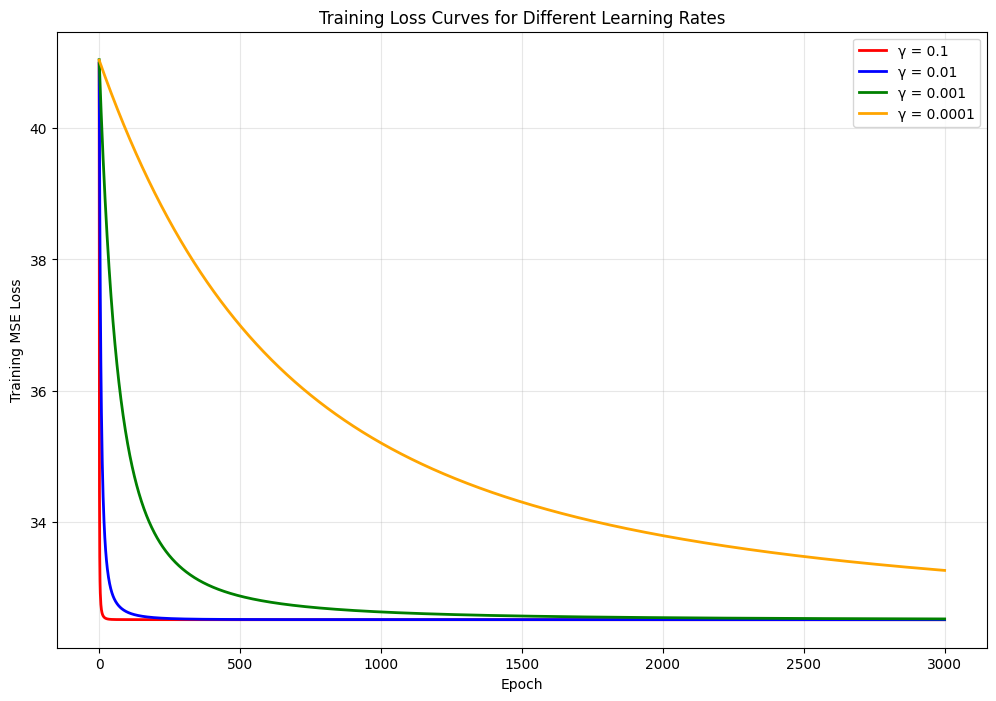


Validation MSE Results:
------------------------------
Learning rate 0.1: Training MSE = 32.504969, Validation MSE = 33.809873
Learning rate 0.01: Training MSE = 32.505642, Validation MSE = 33.806861
Learning rate 0.001: Training MSE = 32.517023, Validation MSE = 33.810333
Learning rate 0.0001: Training MSE = 33.257232, Validation MSE = 34.828890


In [9]:
learning_rates = [10**-i for i in range(0,5)]

w_list = []
train_losses_list = []
converged_rates = []
val_mse_list = []

for i, lr in enumerate(learning_rates):
    print(f"Learning rate: {lr}")
    
    w, losses = batch_gradient_descent(X_train.to_numpy(), y_train.to_numpy(), gamma=lr, T=3000)
    
    # Check if converged (no NaN values)
    if not np.any(np.isnan(w)) and not np.any(np.isnan(losses)):
        w_list.append(w)
        train_losses_list.append(losses)  # Fix: was appending w instead of losses
        converged_rates.append(lr)
        
        # Calculate validation MSE
        y_val_pred = X_val.to_numpy() @ w
        val_mse = np.mean((y_val_pred - y_val.to_numpy())**2)
        val_mse_list.append(val_mse)

print(f"\nConverged learning rates: {converged_rates}")

# Plot training loss curves for converging learning rates
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, (lr, losses) in enumerate(zip(converged_rates, train_losses_list)):
    plt.plot(losses, color=colors[i % len(colors)], label=f'γ = {lr}', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Training MSE Loss')
plt.title('Training Loss Curves for Different Learning Rates')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Validation MSE for each converging learning rate
print("\nValidation MSE Results:")
print("-" * 30)
for lr, train_mse, val_mse in zip(converged_rates, train_losses_list, val_mse_list):
    print(f"Learning rate {lr}: Training MSE = {train_mse[-1]:.6f}, Validation MSE = {val_mse:.6f}")


## ✍️ Question

Which learning rate leads to the best training and validation MSE respectively? Do you observe better training MSE tend to correpsond to better validation MSE? How is this different from the trend shown on page 52 (or vicinity) of the lecture slides (titled 'danger of using training loss to select M') regarding overfitting? Is there any issue with using training loss to pick learning rate in this case?

**Answer:**
**The 0.1 learning rate leads to the best training MSE, while the learning rate of 0.01 leads to the best validation MSE. In this case better training MSE does tend to correspond to better validation MSE. The lecture slides mention that this is not always the case and good training MSE performance might lead to overfitting causing bad validation MSE performance. In this case there's no issue in using the training loss to pick a learning rate since we do not observe overfitting, that is the validation loss remains very close to the training loss.**

# Part 3. More exploration.

## **3(a). (25 pts) Normalization of features: what is the impact?**
In part 1, you were asked to perform z-score normalization of all the features. In this part, we will ask you to first conceptually think about what is the impact this operation on the solution and then use some experiments to varify your conceptual understanding.

## ✍️ **Questions.**

The normalization process applies a linear transformation to each feature, where the transformed feature $x'$ is simply a linear function of original feature $x$: $x'=\frac{x-\mu}{\sigma}$.

Let's disect the influence of this transformation on our learned linear regression model.
1. How do you think this transformation will influnce the training and validation MSE we get for the closed-form solution? Why?
2. How do you think this will change the magnitude of the weights of the learned model? Why?
3. How do you think this will change the convergence behavior of the batch gradient descent algorithm? Why?

**Answer**

**1.- It does not directly affect the training and validation MSE as normalization is only a linear transformation it doesn't affect the expressive power of the model.**

**2.-Normalization is helping by keeping the scale of the input bounded and thus keeping the scale of the weights similar to each other. This is because without normalization features at different scales for example on the 1000-2000 would require much smaller weights than features on a range from 1-10 in order to lead to the same loss. This can lead to weights becoming numerically unstable reaching really high or small values.**

**3.-Since weights will be similar to each other in scale, the gradients will be smaller and not explode leading to divergence as we saw with the learning rate of 1.**

## 🚧Experimental verification
Now please perform the following experiments to verify your answer to the above questions.
1. Apply 'closed_form_linear_regression' to training data that did not go through the feature normalization step, and report the learned weights and the resulting training and testing MSEs.

2. Apply 'batch_gradient_descent' to training data that did not go through the feature normalization step using different learning rates. Note that the learning rate used in previous section will no longer work here. You will need to search for an appropriate learning rate to get some converging behavior. Plot your MSE loss curve as a function of the epochs once you identify a convergent learning rate.
Hint: the learning rate needs to be much, much,much, much, much, much, much smaller (think about each much as an order of manitude) than what was used in part 2). Also unless you let it run for a long time, it is unlikely to converge to the same level of loss values. So use a reasonable upper bound on the # of iterations so that it won't take forever.

In [10]:
X_train, X_val, y_train, y_val = preprocess(train_df, val_df, normalize=False)

w=closed_form_linear_regression(X_train.to_numpy(), y_train.to_numpy())

y_train_pred = X_train.to_numpy() @ w

mse_train = np.mean((y_train_pred - y_train.to_numpy())**2)

y_val_pred = X_val.to_numpy() @ w 

mse_val = np.mean((y_val_pred - y_val.to_numpy())**2)

print(f"MSE_Train: {mse_train}")
print(f"MSE_Val: {mse_val}")

print(f"Learned weight vector: {w}")

MSE_Train: 3.7686106911822304
MSE_Val: 4.5137334191487515
Learned weight vector: [-2.94622619e-01  4.40302398e-01  9.83296271e-04  1.34808783e-06
  4.75742207e-02  4.00633176e+00  5.97628402e-01  2.90559754e-01
  9.53000682e-01  7.61708663e-04  2.21651631e-04 -2.63179707e-02
  1.29687505e-04 -5.54066885e-03  6.00687233e+00 -2.13423778e+00
  1.94869628e-04 -3.43645905e-06 -6.95739410e-03  2.08792942e-02
 -2.31242874e-02  6.95894668e-04]


Learning rate: 1e-10


/home/magraz/venvs/ml-class/lib/python3.10/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_20421/4213706113.py:27: RuntimeWarning: overflow encountered in square
  mse_loss = np.mean((y_pred-y)**2)


Learning rate: 1e-11
Learning rate: 1e-12
Learning rate: 1e-13
Learning rate: 1e-14

Converged learning rates: [1e-11, 1e-12, 1e-13, 1e-14]


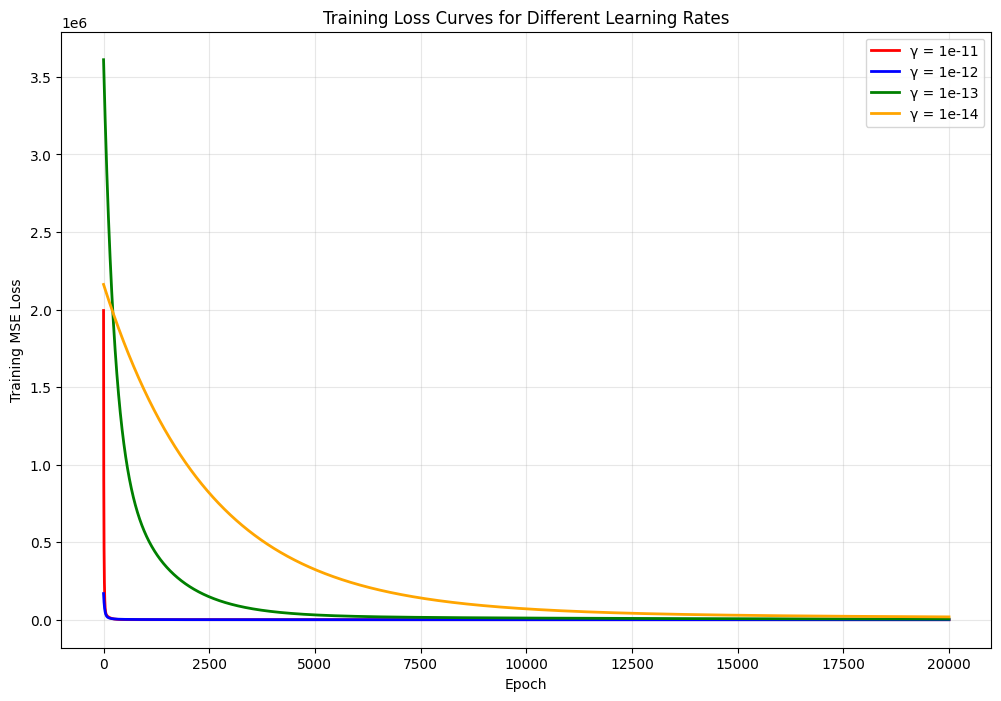


Validation MSE Results:
------------------------------
Learning rate 1e-11: Training MSE = 173.270792, Validation MSE = 168.454900
Learning rate 1e-12: Training MSE = 117.050686, Validation MSE = 107.265914
Learning rate 1e-13: Training MSE = 3894.523824, Validation MSE = 3202.247206
Learning rate 1e-14: Training MSE = 18408.103932, Validation MSE = 17696.319224


In [11]:
learning_rates = [10**-i for i in range(10,15)]

w_list = []
train_losses_list = []
converged_rates = []
val_mse_list = []

for i, lr in enumerate(learning_rates):
    print(f"Learning rate: {lr}")
    
    w, losses = batch_gradient_descent(X_train.to_numpy(), y_train.to_numpy(), gamma=lr, T=20000)
    
    # Check if converged (no NaN values)
    if not (np.any(np.isnan(w)) or np.any(np.isinf(w))) and not (np.any(np.isnan(losses)) or np.any(np.isinf(losses))):
        w_list.append(w)
        train_losses_list.append(losses)  # Fix: was appending w instead of losses
        converged_rates.append(lr)
        
        # Calculate validation MSE
        y_val_pred = X_val.to_numpy() @ w
        val_mse = np.mean((y_val_pred - y_val.to_numpy())**2)
        val_mse_list.append(val_mse)

print(f"\nConverged learning rates: {converged_rates}")

# Plot training loss curves for converging learning rates
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, (lr, losses) in enumerate(zip(converged_rates, train_losses_list)):
    plt.plot(losses, color=colors[i % len(colors)], label=f'γ = {lr}', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Training MSE Loss')
plt.title('Training Loss Curves for Different Learning Rates')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Validation MSE for each converging learning rate
print("\nValidation MSE Results:")
print("-" * 30)
for lr, train_mse, val_mse in zip(converged_rates, train_losses_list, val_mse_list):
    print(f"Learning rate {lr}: Training MSE = {train_mse[-1]:.6f}, Validation MSE = {val_mse:.6f}")

In [12]:
# Let's debug this step by step
print("=== DEBUGGING NORMALIZATION EFFECT ===")

# Get both normalized and unnormalized data
X_train_norm, X_val_norm, y_train_norm, y_val_norm = preprocess(train_df, val_df, normalize=True)
X_train_unnorm, X_val_unnorm, y_train_unnorm, y_val_unnorm = preprocess(train_df, val_df, normalize=False)

# Verify target variables are identical
print(f"Target variables identical: {np.allclose(y_train_norm, y_train_unnorm)}")
print(f"Target variables identical (val): {np.allclose(y_val_norm, y_val_unnorm)}")

# Train both models
w_norm = closed_form_linear_regression(X_train_norm.to_numpy(), y_train_norm.to_numpy())
w_unnorm = closed_form_linear_regression(X_train_unnorm.to_numpy(), y_train_unnorm.to_numpy())

# Make predictions using vectorized operations (more reliable)
y_train_pred_norm = X_train_norm.to_numpy() @ w_norm
y_val_pred_norm = X_val_norm.to_numpy() @ w_norm

y_train_pred_unnorm = X_train_unnorm.to_numpy() @ w_unnorm
y_val_pred_unnorm = X_val_unnorm.to_numpy() @ w_unnorm

# Calculate MSE using vectorized operations
mse_train_norm = np.mean((y_train_pred_norm - y_train_norm.to_numpy())**2)
mse_val_norm = np.mean((y_val_pred_norm - y_val_norm.to_numpy())**2)

mse_train_unnorm = np.mean((y_train_pred_unnorm - y_train_unnorm.to_numpy())**2)
mse_val_unnorm = np.mean((y_val_pred_unnorm - y_val_unnorm.to_numpy())**2)

print("\n=== NORMALIZED DATA ===")
print(f"Training MSE: {mse_train_norm:.6f}")
print(f"Validation MSE: {mse_val_norm:.6f}")
print(f"Weight range: [{np.min(w_norm):.6f}, {np.max(w_norm):.6f}]")

print("\n=== UNNORMALIZED DATA ===")
print(f"Training MSE: {mse_train_unnorm:.6f}")
print(f"Validation MSE: {mse_val_unnorm:.6f}")
print(f"Weight range: [{np.min(w_unnorm):.6f}, {np.max(w_unnorm):.6f}]")

print(f"\n=== DIFFERENCES ===")
print(f"Training MSE difference: {mse_train_unnorm - mse_train_norm:.6f}")
print(f"Validation MSE difference: {mse_val_unnorm - mse_val_norm:.6f}")

# Check if predictions are actually the same
print(f"Predictions close (train): {np.allclose(y_train_pred_norm, y_train_pred_unnorm, rtol=1e-10)}")
print(f"Predictions close (val): {np.allclose(y_val_pred_norm, y_val_pred_unnorm, rtol=1e-10)}")

# Check for numerical issues
print(f"\nNumerical checks:")
print(f"Any NaN in normalized weights: {np.any(np.isnan(w_norm))}")
print(f"Any NaN in unnormalized weights: {np.any(np.isnan(w_unnorm))}")
print(f"Any Inf in normalized weights: {np.any(np.isinf(w_norm))}")
print(f"Any Inf in unnormalized weights: {np.any(np.isinf(w_unnorm))}")

=== DEBUGGING NORMALIZATION EFFECT ===
Target variables identical: True
Target variables identical (val): True

=== NORMALIZED DATA ===
Training MSE: 32.504969
Validation MSE: 33.809878
Weight range: [-0.762911, 1.117195]

=== UNNORMALIZED DATA ===
Training MSE: 3.768611
Validation MSE: 4.513733
Weight range: [-2.134238, 6.006872]

=== DIFFERENCES ===
Training MSE difference: -28.736358
Validation MSE difference: -29.296144
Predictions close (train): False
Predictions close (val): False

Numerical checks:
Any NaN in normalized weights: False
Any NaN in unnormalized weights: False
Any Inf in normalized weights: False
Any Inf in unnormalized weights: False


## ✍️ Questions

Please revisit the questions above. Does your experiment confirm your expectation?  Can you provide explanations to the observed differences (or lack of differences) between the normalized data and unnormalized data? Based on these observations and your understanding of them, please comment on the benefits of normalizing the input features in learning for linear regressions.


**Answer**

**In my answer to the first question I expected the loss to remain similar and only the weights to change in magnitude. However the loss of the closed form solution was reduced greatly when not normalizing. I hypothesize that normalization distorted meaningful relationships between the features or it magnified the noise of feeatures with very small variation range.**

## **3(b). (15 pts) Explore the impact of correlated features**

In the warm up exercise, you all have seen some features are highly correlated with one another. For example, there are multiple squared footage related features that are strongly correlated (e.g., *sqft_above* and *sqrt_living* has a correlation coefficient of 0.878).  This is referred to as multicollinearity phenomeon, where two or more features are correlated.

There are numerous consequences from multicollinearity. It makes it more challenging to estimate the weights of the features accurately. The weights may become unstable, and their interpretation becomes less clear.

In this part you will work with the pre-processed training set, and perform the following experiments to examine how correlated features affect the stability of learned weights.

 ## 🚧Experiment to investigate impact of correlated features
Conduct following experiments.
1. **Create five training subsets**:  Randomly subsample 75% of the orginial preprocessed training set to form five slightly different training sets.
2. **Fit models**:  Use your 'closed_form_linear_regression' function to train a linear regression model on each of the five training sets.
3. **Report learned weights in a table**:  
   - The table should have **five rows** (one for each model)  
   - Each column corresponds to a **feature’s weight**  
   - Include a **header row** with the feature names

4. **Report the variance of weights across models**:  
   Include an additional row to the above table to report for each feature, the variance of its learned weight coefficients across the five models.  This variance serves as a measure of the **stability** of the weight assigned to each feature. Larger variance suggests lower stability.
  
  Note: We use 5 random training subset here to get a rough sense of weight stability. For more robust analysis, you could increase this to 10 or more runs.



In [13]:
X_train, X_val, y_train, y_val = preprocess(train_df, val_df)

# Set random seed for reproducibility
np.random.seed(42)

# Create five training subsets (75% of original data each)
n_subsets = 5
subset_size = int(0.75 * len(X_train))
weights_list = []
feature_names = X_train.columns.tolist()

print(f"Original training set size: {len(X_train)}")
print(f"Each subset size: {subset_size} (75% of original)")
print()

# Generate and train on five subsets
for i in range(n_subsets):
    # Randomly sample 75% of the data
    indices = np.random.choice(len(X_train), size=subset_size, replace=False)
    
    X_subset = X_train.iloc[indices]
    y_subset = y_train.iloc[indices]
    
    # Train model on this subset
    w = closed_form_linear_regression(X_subset.to_numpy(), y_subset.to_numpy())
    weights_list.append(w)

# Convert to numpy array for easier manipulation
weights_array = np.array(weights_list)

# Create DataFrame for better visualization
weights_df = pd.DataFrame(weights_array, 
                         columns=feature_names,
                         index=[f'Model_{i+1}' for i in range(n_subsets)])

# Calculate variance for each feature across models
variance_row = weights_array.var(axis=0)
variance_df = pd.DataFrame([variance_row], 
                          columns=feature_names, 
                          index=['Variance'])

# Combine weights and variance
results_df = pd.concat([weights_df, variance_df])

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("\nLearned weights for each model and their variances:")
print("=" * 80)
print(results_df.round(8))

# Show features with highest variance (least stable)
print(f"\nTop 5 features with highest weight variance (least stable):")
print("-" * 60)
variance_sorted = variance_row.argsort()[::-1]
for i in range(5):
    feature_idx = variance_sorted[i]
    feature_name = feature_names[feature_idx]
    variance_val = variance_row[feature_idx]
    print(f"{i+1}. {feature_name}: {variance_val:.6f}")

# Show features with lowest variance (most stable)
print(f"\nTop 5 features with lowest weight variance (most stable):")
print("-" * 60)
for i in range(5):
    feature_idx = variance_sorted[-(i+1)]
    feature_name = feature_names[feature_idx]
    variance_val = variance_row[feature_idx]
    print(f"{i+1}. {feature_name}: {variance_val:.6f}")

Original training set size: 8000
Each subset size: 6000 (75% of original)


Learned weights for each model and their variances:
          bedrooms  bathrooms  sqft_living  sqft_lot    floors  waterfront  \
Model_1  -0.265834   0.319153     0.764323  0.043360  0.028599    0.333203   
Model_2  -0.369285   0.317283     0.819275  0.125775  0.069120    0.356777   
Model_3  -0.248645   0.286185     0.798260 -0.012806  0.016025    0.370290   
Model_4  -0.242542   0.340206     0.762749  0.108563 -0.012835    0.421986   
Model_5  -0.344253   0.326750     0.832291  0.105431 -0.046858    0.390547   
Variance  0.002738   0.000317     0.000794  0.002667  0.001526    0.000910   

              view  condition     grade  sqft_above  sqft_basement  yr_built  \
Model_1   0.467356   0.275774  1.157353    0.750933       0.167443 -0.956689   
Model_2   0.443376   0.150580  1.102118    0.803102       0.182945 -0.558814   
Model_3   0.443838   0.197926  1.112912    0.777138       0.188467 -0.871806   
Model

In [14]:
correlation_matrix = X_train.corr()

# Display correlation matrix
print("Feature Correlation Matrix:")
print("=" * 80)
print(correlation_matrix.round(3))

# Find highly correlated feature pairs (correlation > 0.7)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                corr_val
            ))

print(f"\nHighly correlated feature pairs (|correlation| > 0.7):")
print("-" * 60)
for feat1, feat2, corr in high_corr_pairs:
    print(f"{feat1} <-> {feat2}: {corr:.3f}")

Feature Correlation Matrix:
                     bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
bedrooms                1.000      0.484        0.562     0.025   0.165   
bathrooms               0.484      1.000        0.750     0.071   0.511   
sqft_living             0.562      0.750        1.000     0.165   0.354   
sqft_lot                0.025      0.071        0.165     1.000  -0.013   
floors                  0.165      0.511        0.354    -0.013   1.000   
waterfront             -0.011      0.027        0.068     0.035   0.015   
view                    0.087      0.186        0.281     0.078   0.036   
condition               0.027     -0.140       -0.065    -0.013  -0.267   
grade                   0.339      0.664        0.758     0.102   0.466   
sqft_above              0.463      0.685        0.879     0.177   0.522   
sqft_basement           0.293      0.263        0.417     0.007  -0.253   
yr_built                0.143      0.510        0.315     0.048   0.489 

## ✍️ Questions
Ideally, we want the learned weight coefficients to be **stable across different runs**, as this indicates a more **reliable and interpretable** model.
- Based on the variances you computed:
  - Do features with **high correlation to others** tend to show **more instability** in their weights across different training subsets?
  - What trends do you observe?
- Use a **correlation matrix** of the input features to support your observations. Which features appear most correlated?
- What implications does this have for interpreting feature importance in your model?


**Your answer goes here.**

**Looking at the sqft_living and sqft_above features both of which are highly correlated, we can see that their variance is very low. The same can be said for the features grade, yr_built, age_since_renovated, year and month. This aligns with the correlation matrix shown above.**

**The most correlated features are: bathrooms, sqft_living, sqft_above, grade, sqft_lot, yr_built, age_since_renovated, year and month. The features most positively correlated to each other are sqft_living and sqft_above, and the most negatively correlated features to each other are yr_built and age_since_renovated.**

****

# Kaggle competition (10 pts)
In this section, you will try to build your best model on the given training data and apply it to the provided test data and submit the predictions for the class-wide competition on Kaggle.

**Model restriction.** You must use linear regression (without regularization) as your predictive model. No advanced models, such as Ridge, Lasso, tree-based models, neural networks, or other complex learners are not allowed.

**Implementation note.** For this part, you are allowed to use a standard library implementation (e.g., 'sklearn.linear_model.LinearRegression') to speed up experimentation.

**Exploration encouraged.** You are encouraged to explore:
- feature engineering such as removing, transforming features, constructing new features based on existing ones, using different encoding for the discrete features;
- training data filtering/modification such as identifying and removing potential outliers in the training data;
- target manipulation such as normalizing, or log transforming the prediction target

**Fair play and have fun!** The spirit of this competition is for you to learn how far linear regression can go when paired with thoughtful data preparation.

To participate in this competition, use the following link:
https://www.kaggle.com/t/7e07d14f327c4ee1babd526d4ccf0701


**Team work.** You should continue working in the same team for this competition. Make sure to note in your submission your kaggle team name.

**How to sumbit.**
Your submission should include the prediction for every test sample. The file must be a CSV with two columns: `id` and `price`.
- `id` is the unique identifier for each instance as provided in the test data PA1_test1.csv  
- `price` is your predicted result.
Your file should start with a header row (`id, price`) and followed by $N$ rows, one per test sample.


**Competition evluation. ** The competition has two leaderboards: the public leader board as well as the private leader board. The results on the public leader board are visible through out the competition so that you can tell how well your model works compared to others and use it to pick the best models to make submission for the private leader board. Each team will be allowed to submit 3 entries to be evaluated on the private leaderboard for the final performance. The results on the private leaderboard will be released after the competition is closed.

**Points and bonus points.** You will get the full 10 points if you
- participate in the competition (successful submissions)

- achieve non-trivial performance (outperform some simple baseline)

- complete the report on the competition below.

You will get **3 nonus points** if your team scored top 3 on the private leader board, or entered the largest number of unique submissions (unique sores).

**No late submission.** The competition will be closed at 11:59 pm of the due date. No late submission will be allowed for this portion of the assignment to ensure fairness.


In [ ]:
from sklearn.linear_model import LinearRegression
train_val_path = './PA1_train1.csv'
test_path = './PA1_test1.csv'

train_val_df = pd.read_csv(train_val_path)
test_df = pd.read_csv(test_path)

train_val_df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,3066410850,7/9/2014,4,2.50,2720,10006,2.0,0,0,3,9,2720,0,1989,0,98074,47.6295,-122.042,2720,10759,5.9495
1,9345400350,7/18/2014,2,2.50,2600,5000,1.0,0,0,5,8,1300,1300,1926,0,98126,47.5806,-122.379,2260,5000,6.6500
2,7128300060,7/7/2014,5,1.75,1650,3000,1.5,0,0,3,8,1650,0,1902,0,98144,47.5955,-122.306,1740,4000,4.4300
3,2155500030,4/28/2015,4,1.75,1720,9600,1.0,0,0,4,8,1720,0,1969,0,98059,47.4764,-122.155,1660,10720,3.8000
4,3999300080,9/4/2014,6,2.25,3830,11180,1.0,0,2,5,9,2440,1390,1962,0,98008,47.5849,-122.113,2500,10400,8.8700


## ✍️ Report on the Kaggle competition

1. **Team name**:
2. **Exploration Summary:** Brief describe the approches you tried. 3. **Most Impactful Change: ** Which exploration led to the most performance improvement, and why do you think it helped?


In [16]:
#running this code block will convert this notebook and its outputs into a pdf report.
# ⚠️ALERT! Exporting colab notebooks into a clean figure-inclusive pdf can be unreliable.
# Sometimes output figures may not appear in your exported file.
#
#If this happens, please assemble your report mannually: copy relevant fgures/results
# into a separate documents and save as PDF. Be sure to clearly lablel each figure with
# the corresponding part number (e.g., Part 3(b)).).

# !jupyter nbconvert --to html /content/gdrive/MyDrive/Colab\ Notebooks/IA1-2024.ipynb  # you might need to change this path to appropriate value to location your copy of the IA0 notebook
!jupyter nbconvert --to html '/home/magraz/ml-class/HW2/IA1_2025.ipynb'    # you might need to change this path to appropriate value to location your copy of the IA0 notebook

# input_html = '/content/gdrive/MyDrive/Colab Notebooks/IA1-2025.html' #you might need to change this path accordingly
# output_pdf = '/content/gdrive/MyDrive/Colab Notebooks/IA1output.pdf' #you might need to change this path or name accordingly

input_html = '/home/magraz/ml-class/HW2/IA1_2025.html' #you might need to change this path accordingly
output_pdf = '/home/magraz/ml-class/HW2/IA1output.pdf' #you might need to change this path or name accordingly

# Convert HTML to PDF
pdfkit.from_file(input_html, output_pdf)

# Download the generated PDF
# files.download(output_pdf)

[NbConvertApp] Converting notebook /home/magraz/ml-class/HW2/IA1_2025.ipynb to html
[NbConvertApp] Writing 391337 bytes to /home/magraz/ml-class/HW2/IA1_2025.html


True